**Purpose:** Make a network graph using the similarity function.

In [1]:
import os
import string
import pandas as pd
import numpy as np
import networkx as nx
import pubmed_parser as pp
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm.notebook import tqdm

In [2]:
pmids = [26016486, 25749135, 11983860, 21687533, 28828194]
index = list(range(len(pmids)))

In [3]:
def get_article(pmid):
    article = pp.parse_xml_web(pmid, sleep = 1)
    return article

In [4]:
def print_article(article):
    print(article['title'])
    print(article['authors'])
    print(article['journal'])
    print('https://www.ncbi.nlm.nih.gov/pubmed/' + article['pmid'])

In [5]:
def tokenize(words):
    words = words.lower()
    words = words.translate(str.maketrans('', '', string.punctuation))
    tokens = words.split()
    return np.array(tokens)

In [6]:
def content_similarity(article1, article2, weights = (2, 1)):
    title_arr1 = tokenize(article1['title'])
    title_arr2 = tokenize(article2['title'])
    title_ss = len(np.intersect1d(title_arr1, title_arr2))
    
    abstract_arr1 = tokenize(article1['abstract'])
    abstract_arr2 = tokenize(article2['abstract'])
    abstract_ss = len(np.intersect1d(abstract_arr1, abstract_arr2))
    
    content_arr = np.array([title_ss, abstract_ss])
    content_weights = np.array(weights)
    content_ss = np.dot(content_arr, content_weights)
    return content_ss

In [7]:
def keyword_similarity(article1, article2):
    keyword_arr1 = np.array(article1['keywords'].split(';'))
    keyword_arr2 = np.array(article2['keywords'].split(';'))
    keyword_ss = len(np.intersect1d(keyword_arr1, keyword_arr2))
    return keyword_ss

In [8]:
def source_similarity(article1, article2, weights = (1, 1, 1)):
    if article1['journal'] == article2['journal']:
        journal_ss = 1
    else:
        journal_ss = 0
        
    affiliation_arr1 = np.array(article1['affiliation'].split(';'))
    affiliation_arr2 = np.array(article2['affiliation'].split(';'))
    affiliation_ss = len(np.intersect1d(affiliation_arr1, affiliation_arr2))
    
    author_arr1 = np.array(article1['authors'].split('; '))
    author_arr2 = np.array(article2['authors'].split('; '))
    author_ss = len(np.intersect1d(author_arr1, author_arr2))
    
    source_arr = np.array([journal_ss, affiliation_ss, author_ss])
    source_weights = np.array(weights)
    source_ss = np.dot(source_arr, source_weights)
    return source_ss

In [9]:
def similarity(article1, article2):
    content_ss = content_similarity(article1, article2)
    keyword_ss = keyword_similarity(article1, article2)
    source_ss = source_similarity(article1, article2)
    return content_ss, keyword_ss, source_ss

In [10]:
def draw_graph(nodes, weighted_edges):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(weighted_edges)
    nx.draw_networkx(G, with_labels = True, node_color = 'silver')

In [11]:
articles = [get_article(pmid) for pmid in tqdm(pmids)]

In [12]:
content_scores, keyword_scores, source_scores = [], [], []
content_pairs, keyword_pairs, source_pairs = [], [], []

for x, y in list(combinations(index, 2)):
    article1, article2 = articles[x], articles[y]
    content_ss, keyword_ss, source_ss = similarity(article1, article2)

    if content_ss != 0:
        content_scores.append(content_ss)
        content_pairs.append([x, y])
    
    if keyword_ss != 0:
        keyword_scores.append(keyword_ss)
        keyword_pairs.append([x, y])
    
    if source_ss != 0:
        source_scores.append(source_ss)
        source_pairs.append([x, y])

In [13]:
content_pairs_arr = np.array(content_pairs)
keyword_pairs_arr = np.array(keyword_pairs)
source_pairs_arr = np.array(source_pairs)

content_scores_arr = np.array(content_scores).reshape(-1, 1)
keyword_scores_arr = np.array(keyword_scores).reshape(-1, 1)
source_scores_arr = np.array(source_scores).reshape(-1, 1)

content_we = np.concatenate((content_pairs_arr, content_scores_arr), axis = 1)
keyword_we = np.concatenate((keyword_pairs_arr, keyword_scores_arr), axis = 1)
source_we = np.concatenate((source_pairs_arr, source_scores_arr), axis = 1)

In [14]:
for i, article in enumerate(articles):
    print(i)
    print_article(article)
    print('')

0
Staphylococcus aureus infections: epidemiology, pathophysiology, clinical manifestations, and management.
Steven Y C Tong; Joshua S Davis; Emily Eichenberger; Thomas L Holland; Vance G Fowler
Clinical microbiology reviews
https://www.ncbi.nlm.nih.gov/pubmed/26016486

1
Pathogenesis of Staphylococcus aureus abscesses.
Scott D Kobayashi; Natalia Malachowa; Frank R DeLeo
The American journal of pathology
https://www.ncbi.nlm.nih.gov/pubmed/25749135

2
Global changes in gene expression by human polymorphonuclear leukocytes during receptor-mediated phagocytosis: cell fate is regulated at the level of gene expression.
Scott D Kobayashi; Jovanka M Voyich; Cassandra L Buhl; Robert M Stahl; Frank R DeLeo
Proceedings of the National Academy of Sciences of the United States of America
https://www.ncbi.nlm.nih.gov/pubmed/11983860

3
Phages in nature.
Martha Rj Clokie; Andrew D Millard; Andrey V Letarov; Shaun Heaphy
Bacteriophage
https://www.ncbi.nlm.nih.gov/pubmed/21687533

4
Phage therapy: An 

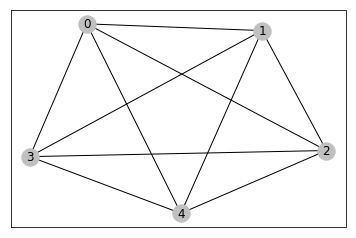

In [15]:
draw_graph(index, content_we) # content similarity network

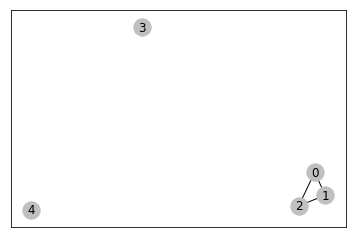

In [16]:
draw_graph(index, keyword_we) # keyword similarity network

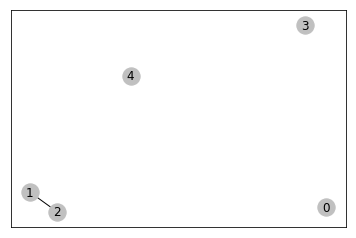

In [17]:
draw_graph(index, source_we) # source similarity network